## Target Maximization

This section covers some budget optimization strategy by leveraging a fitted MMM.

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import pickle

from karpiu.planning import TargetMaximizer
from karpiu.planning.calculator import calculate_marginal_cost, generate_cost_report
from karpiu.explainability import Attributor

pd.set_option("display.float_format", lambda x: "%.5f" % x)
np.set_printoptions(suppress=True)
pd.set_option("display.max_rows", 50)

In [2]:
%load_ext autoreload
%autoreload 2

Bring back the fitted model from previous `Quickstart` section.

In [3]:
with open("./resource/model.pkl", "rb") as f:
    mmm = pickle.load(f)

In [4]:
budget_start = pd.to_datetime("2021-01-01")
budget_end = pd.to_datetime("2021-01-31")
optim_channels = mmm.get_spend_cols()
# to be safe in beta version, use sorted list of channels
optim_channels.sort()

# spend_scaler a fixed constant to reduce over-float of spend
# not that they need to be consistent with the subsequent calculation of
# post optimization metrics
spend_scaler = 1e3

In [5]:
maximizer = TargetMaximizer(
    model=mmm,
    budget_start=budget_start,
    budget_end=budget_end,
    optim_channel=optim_channels,
)
optim_spend_df = maximizer.optimize(maxiter=1000, eps=1e-3)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9949.900140280684
            Iterations: 69
            Function evaluations: 10650
            Gradient evaluations: 68


In [6]:
optim_spend_matrix = maximizer.get_current_state()
init_spend_matrix = maximizer.get_init_state()

In [7]:
# total spend suggest
print("Suggested total spend: {:.0f}".format(np.sum(optim_spend_matrix)))
# total budget
print("Total Budget: {:.0f}".format(np.sum(init_spend_matrix)))

Suggested total spend: 505914
Total Budget: 505914


### Budget Allocation

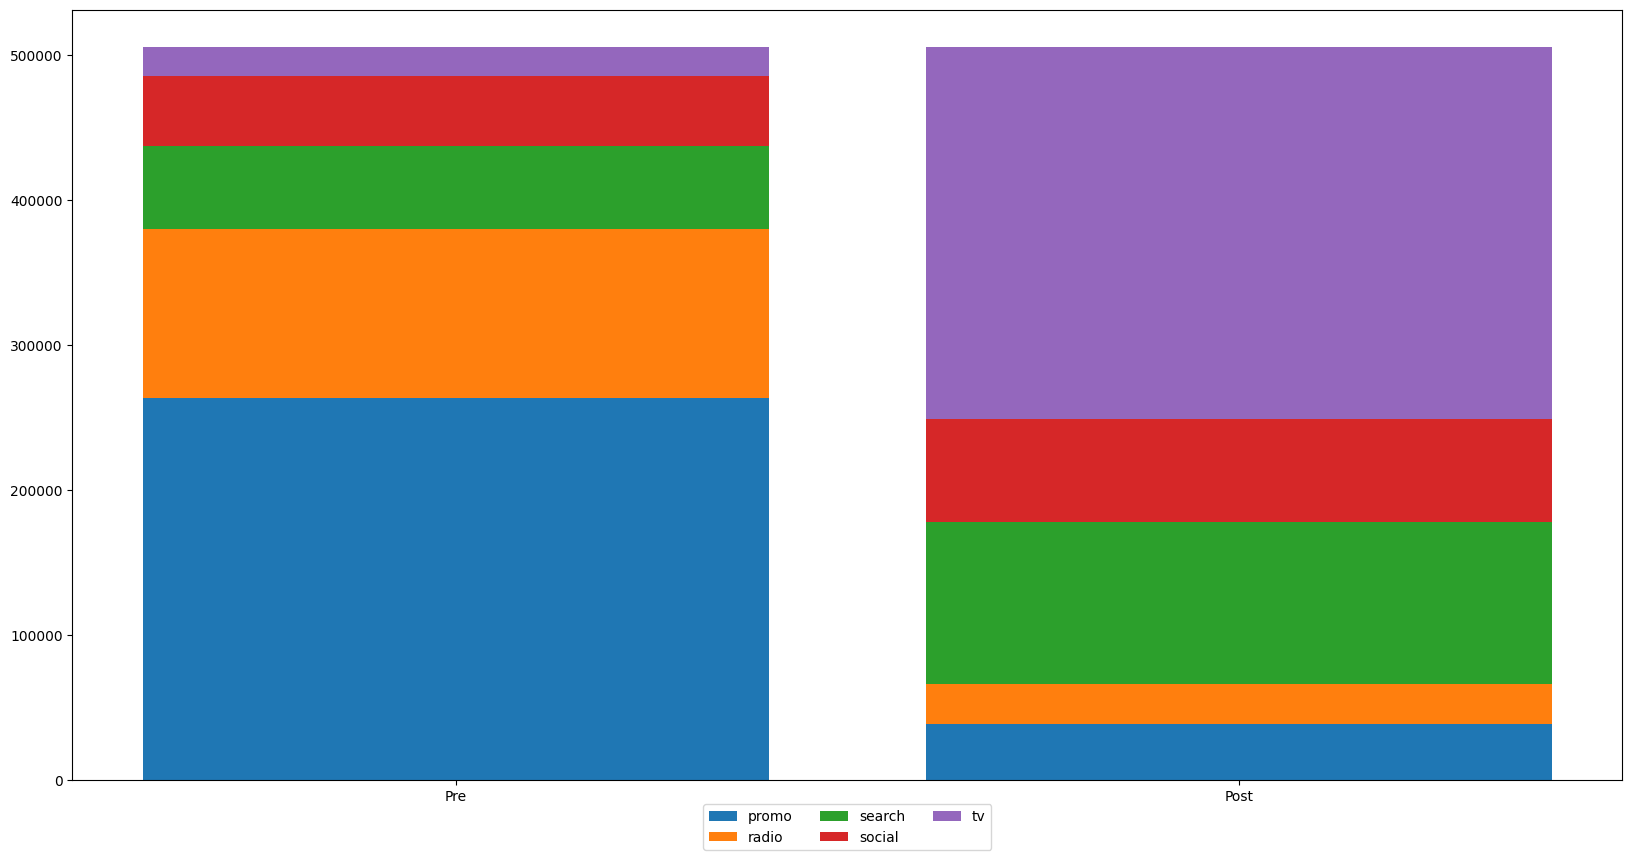

In [8]:
init_total_spend = np.sum(init_spend_matrix, 0)
optim_total_spend = np.sum(optim_spend_matrix, 0)
plot_data = np.vstack([init_total_spend, optim_total_spend])
plot_data.shape

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
bottom = 0.0
for idx, label in enumerate(optim_channels):
    ax.bar(x=["Pre", "Post"], height=plot_data[:, idx], bottom=bottom, label=label)
    bottom += plot_data[:, idx]
# ax.set_title("Spend Allocation Pre vs. Post Optimization")
ax.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.10),
    ncol=math.ceil(len(optim_channels) / 2),
);

### Average and Marginal Cost Change

In [10]:
df = mmm.get_raw_df()

In [11]:
cost_report = generate_cost_report(
    model=mmm,
    channels=optim_channels,
    start=budget_start,
    end=budget_end,
    pre_spend_df=df,
    post_spend_df=optim_spend_df,
)
cost_report

,pre-opt-avg-cost,post-opt-avg-cost,pre-opt-marginal-cost,post-opt-marginal-cost,pre-opt-spend,post-opt-spend
promo,83.77075,41.26717,100.50398,52.93622,263.52400,38.33211
radio,81.57199,39.33204,102.47414,50.31096,116.57600,27.86456
search,30.87272,39.96306,38.85347,49.15137,57.35800,111.57689
social,38.56659,41.64532,46.82680,49.15490,48.16200,71.16741
tv,6.83602,34.72104,8.48145,49.29966,20.29400,256.97303


In [12]:
# check 1: all marginal cost should be close; within 10% of mean
assert np.all(
    np.abs(
        cost_report["post-opt-marginal-cost"].values
        / np.nanmean(cost_report["post-opt-marginal-cost"].values)
        - 1.00
    )
    < 0.1
)

### Outcome Plot

In [13]:
df = mmm.get_raw_df()
optim_pred = mmm.predict(optim_spend_df)
init_pred = mmm.predict(df)

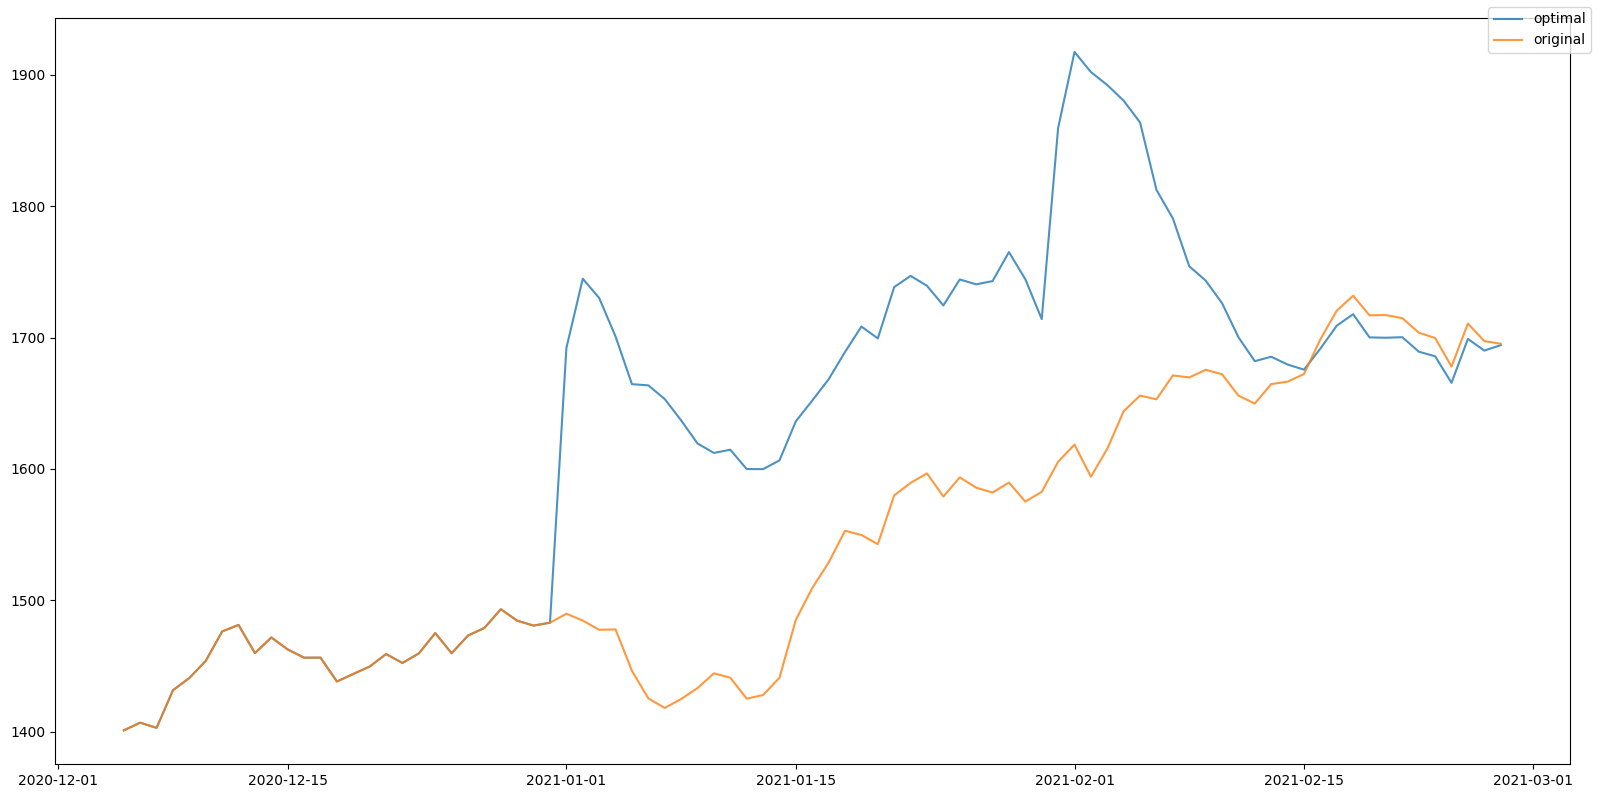

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
measurement_mask = (df["date"] >= maximizer.calc_start) & (
    df["date"] <= maximizer.calc_end
)
ax.plot(
    optim_pred.loc[measurement_mask, "date"].values,
    optim_pred.loc[measurement_mask, "prediction"].values,
    label="optimal",
    alpha=0.8,
)
ax.plot(
    init_pred.loc[measurement_mask, "date"].values,
    init_pred.loc[measurement_mask, "prediction"].values,
    label="original",
    alpha=0.8,
)
fig.legend()
fig.tight_layout();

In [15]:
# check2: total predicted response must be higher than current
total_optim_pred = np.sum(optim_pred.loc[measurement_mask, "prediction"].values)
total_init_pred = np.sum(init_pred.loc[measurement_mask, "prediction"].values)
assert total_optim_pred > total_init_pred